# Benchmark Pan 2014 para esse problema

resultados com micro-avg < 0.30  foram removidos

|Team                  |Dutch    |English    |Greek     |Spanish     |Micro-avg|Macro-avg|
|----------------------|--------:|----------:|---------:|-----------:|--------:|--------:|
|Bagnall               |0.451    |**0.614**  |**0.750** |**0.721**   |0.608    |0.628    |
|Bartoli et al.        |0.518    |0.323      |0.458     |0.773       |0.417    |0.506    |
|Castro-Castro et al.  |0.247    |**0.520**  |0.391     |0.329       |0.427    |0.365    |
|Gómez-Adorno et al.   |0.390    |0.281      |0.348     |0.281       |0.308    |0.323    |
|Gutierrez et al.      |0.329    |0.513      |0.581     |0.509       |0.479    |0.478    |
|Halvani               |0.455    |0.458      |0.493     |0.441       |0.445    |0.462    |
|Hürlimann et al.      |0.616    |0.412      |0.599     |0.539       |0.487    |0.538    |
|Kocher & Savoy        |0.218    |0.508      |0.631     |0.366       |0.435    |0.416    |
|Maitra et al.         |0.518    |0.347      |0.357     |0.352       |0.378    |0.391    |
|Moreau et al.         |**0.635**|0.453      |**0.693** |0.661       |0.534    |0.606    |
|Pacheco et al.        |0.624    |0.438      |0.517     |0.663       |0.480    |0.558    |
|PAN15-ENSEMBLE        |0.426    |0.468      |0.537     |0.715       |0.475    |0.532    |
|PAN14-BASELINE-1      |0.255    |0.249      |0.198     |0.443       |0.269    |0.280    |
|PAN14-BASELINE-2      |0.191    |0.409      |0.412     |0.683       |0.406    |0.405    |
|PAN13-BASELINE        |0.242    |0.404      |0.384     |0.367       |0.358    |0.347    |

## Bibliotecas

In [39]:
%matplotlib inline
#bibliotecas padrões do python
import os;
import codecs;
import re;
import math;
import pickle;
from __future__ import print_function;

#bibliotecas científicas
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import random;


#bibliotecas para machine learning
from sklearn.pipeline import Pipeline;
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer;

from sklearn.metrics.pairwise  import cosine_similarity, paired_distances, rbf_kernel, manhattan_distances;
from sklearn.preprocessing     import RobustScaler, MaxAbsScaler, MinMaxScaler, normalize, Normalizer;
from sklearn.decomposition     import PCA;
from sklearn.feature_selection import SelectPercentile,SelectFpr, f_classif, chi2;
from sklearn.model_selection   import StratifiedKFold,  GridSearchCV;
from sklearn.pipeline          import Pipeline;
from sklearn.metrics           import f1_score, pairwise_distances, precision_recall_fscore_support, roc_auc_score, accuracy_score;

from sklearn.linear_model      import LogisticRegression;
from sklearn.metrics           import classification_report, roc_curve;


import seaborn as sns;

import statsmodels.discrete.discrete_model as sm;

#bibliotecas customizadas.
from toolboxAnalytics import  rocKS, rocCurve, ksCurve, desenhaLogistica;
from IPython.core.display import display, HTML, Markdown;

np.set_printoptions(precision=3);

## Leitura dos datasets por tipo

In [ ]:
def readFiles(path, problemID):
    #lendo os textos do autor conhecido
    known = "";
    for i in xrange(5):
        fname = os.path.join(path,"known0"+str(i)+".txt");
        if os.path.exists(fname):
            with codecs.open(fname) as f:
                known += f.read();
                
    #lendo o texto desconhecido
    with codecs.open(os.path.join(path,"unknown.txt")) as f:
        unknown = f.read();
        
    return (problemID, known, unknown);

#reading all folders /instances of the problem

#método para ler uma instancia e transformar em dataframe
def readInstanceAsDataFrame(task, corpus):
    print ("reading the task %s - %s " % (task, corpus));
    
    #cada task contem uma pasta para cada instancia de problema. 
    #ler todas as pastas e transformar uma tupla /dataframe
    path = os.path.join(r'.\trainingData', 'pan14-author-verification-'+corpus+'-'+task+'-2014-04-22')
    problems = [readFiles(os.path.join(path,problemID),problemID)
                    for problemID in os.listdir(path)
                            if os.path.isdir(os.path.join(path,problemID))
               ];
    problemID, known, unknown = zip(*problems);
    dfData = pd.DataFrame({'problemID':problemID,'known':known, 'unknown':unknown});
    
    #lendo o arquivo texto com o ground truth
    dfProblem = pd.read_table(
                    os.path.join(path,"truth.txt"),
                    sep=' ',
                    header=None,
                    names=['problemID','truth']
                );
    
    
    #criando um dataset unico;
    dataset = pd.merge(dfData, dfProblem, on='problemID');
    dataset['genre'] = task.split('-')[1];
    dataset['task'    ] = task;
    dataset['language'] = task.split("-")[0];
    dataset['corpus'  ] = corpus;
    return dataset[['corpus','problemID','language','genre','task', 'known','unknown','truth']];

In [ ]:
tasks = ['dutch-essays', 'dutch-reviews','english-essays','english-novels', 'greek-articles', 'spanish-articles'];
corpus = ['training-corpus','test-corpus1','test-corpus2']
dataset = [
        readInstanceAsDataFrame(t, c)
            for t in tasks
                for c in corpus
        ]
dataset = pd.concat(dataset);

dataset.head()

In [ ]:
display(HTML("<span style='color:red'> Salvando banco de dados consolidado </span>"));
with codecs.open("PAN2014consolidado.json",'w') as f:
    f.write(dataset.reset_index().to_json());

# Partindo dos dados consolidados previamente

In [2]:
display(HTML("<span style='color:red'> Lendo banco de dados consolidado </span>"));
with codecs.open("PAN2014consolidado.json",'r') as f:
    dataset = pd.read_json(f.read())

### Filtrando apenas espanhol e inglês e base de treinamento

In [3]:
dataset = dataset[((dataset.language != 'dutch') & (dataset.language != 'greek') )];
dataset.drop('corpus',axis=1, inplace=True);

In [4]:
dataset.head()

,genre,index,known,language,problemID,task,truth,unknown
1000,novels,10,IV. A Mutation and a Madness\n\n1.\n\nIn the w...,english,EN011,english-novels,Y,III.\n\nMeanwhile Old Whateley continued to bu...
1001,novels,11,"﻿Spoonbill Village, Northernmost Quang Binh Pr...",english,EN012,english-novels,Y,"﻿May 19th, 1929,\nMiskatonic University, Arkha..."
1002,novels,12,III. A Search and an Evocation\n\n1.\n\nCharle...,english,EN013,english-novels,Y,"“Gorgons, and Hydras, and Chimaeras—dire stori..."
1003,novels,13,﻿Day 1-I never would imagine such thing would ...,english,EN014,english-novels,N,V.\n\nThe following winter brought an event no...
1004,novels,14,"""The essential Saltes of Animals may be so pre...",english,EN015,english-novels,N,"﻿Ordinarily, one wouldn't think of the Dreamer..."


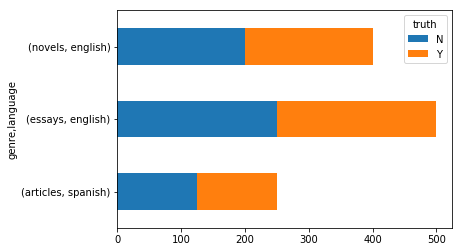

In [5]:
dataset\
.pivot_table(values='problemID',index=['genre','language'],columns='truth',aggfunc='count') \
.plot.barh(stacked=True);

# Funções utilitárias

In [6]:
def histograma(title, var, truth):
    """
    Essa função desenha 2 histogramas sobrepostos. 1 com a classe positiva e outro a classe negativa.
    Isso permite verificar visualmente o poder de separação da variável com relação as classes.
    
    Ps.:  O poder total de separação deve ser verificado pela função
    ksCurve que plota a curva acumulada e o poder de separação todal.
    """
    plt.title(title)
    plt.hist(var[truth == 'N'], label=u"outro autor", bins=30, color='#CC2222', alpha=0.5);
    plt.hist(var[truth == 'Y'], label=u"mesmo autor", bins=30, alpha=0.5);
    plt.xlabel(u"Distância");
    plt.legend(loc='upper right')

In [7]:
def KS_Hist_chart(X, Y, varName = u'Variável x'):
    colors = ['#0000cc', '#cc0000']
    for i in (0,1):
        d = X[Y==i];
        plt.hist(d, alpha=0.75, color=colors[i], bins=30, label="Y="+str(i));
    plt.twinx();
    l=[];
    for i in (0,1):
        d = np.argsort(X);
        d2 = Y[d];
        d2 = (d2==i).cumsum();
        d2 = d2/(1.0*d2.max());
        l.append(d2);
        plt.plot(X[d],d2, color=colors[i] , label="Y="+str(i),  alpha=0.75);
    ks = np.max(np.abs(l[0]-l[1]));
    plt.title(" %s - KS = %0.2f" % (varName,ks));
    plt.legend(loc='upper right');
    plt.xlabel(u"Distribuicao acumulada");
    return ks;

In [8]:
def pcaCutOff(pca, cutVariance =0.95, plot=False):
    """Esse método calcula quantas componentes são necessário para explicar  o percentual de variancia desejada."""
    variance = pca.explained_variance_ratio_.cumsum();
    cutoff = len(variance[variance< cutVariance]);
    
    if plot:
        plt.figure(1, figsize=(10,5))
        plt.clf()
        plt.axes([.2, .2, .7, .7])
        plt.plot(variance, linewidth=2)
        plt.axvline(x=cutoff)
        plt.axis('tight')
        plt.xlabel('n_components')
        plt.ylabel('explained_variance_')
    return cutoff;

In [9]:
def cosine(matrixA, matrixB):
    """Essa função calcula a similaridade de cossenos entre duas matrizes e retorna um vetor que representa
    cosine[i] =  cosine(matrixA[i,:], matrixB[i,:])
    como preprocessamento, a matrizes passam por um normalização L2 para evitar que a norma influencie
    """
    return np.array(np.diag(
        cosine_similarity(
            normalize(matrixA, norm='l2'),
            normalize(matrixB, norm='l2')
        )
    )).flatten();

In [10]:
def pcaSimilarity(pca, matrixA, matrixB):
    """calcula a similaridade considerando apenas algumas componentes da PCA"""
    pcaknownCount   = pca.transform(matrixA);
    pcaunknownCount = pca.transform(matrixB);    
    cpca = cosine(pcaknownCount,pcaunknownCount);
    return cpca;

In [11]:
def CNG_Keselj(matrixA, matrixB):
    """
    A profile-based method of particular interest, the Common n-Grams (CNG) approach, was described by Keselj, et al. (2003).
    -1 vetor A tem valores maiores
    0  A e B são iguais
    1  vetor B  tem valores maiores
    """
    dif   = (matrixA) - (matrixB);
    summ   = (matrixA) + (matrixB);
    with np.errstate(divide='ignore', invalid='ignore'):
        s = (2 * dif /summ) **2;
    s = np.array(np.nanmean(s, axis=1)).flatten();    
    return s;

In [12]:
def CNG_Statamatos(matrixA, matrixB):
    #difference to local
    s1 = (2 * (matrixA - matrixB) /(matrixA + matrixB)) **2;    
    with np.errstate(divide='ignore', invalid='ignore'):
        #global difference
        matrixCorpus = np.vstack((matrixA,matrixB));
        matrixCorpus =  normalize(np.sum(matrixCorpus,axis=0, keepdims=True), norm='l1');   
        s2 = (2 * (matrixA - matrixCorpus) /(matrixA + matrixCorpus)) **2;
    
    s = s1 * s2;    
    s = np.array(np.nanmean(s, axis=1)).flatten();    
    return s;

\begin{equation*}
D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}.
\end{equation*}

In [13]:
def KL_divergence(matrixA, matrixB):
    with np.errstate(divide='ignore', invalid='ignore'):
        s = matrixA * np.log(matrixA/matrixB);
        #substituindo infinito da divisão por zero pelo zero
        s [s == np.inf] = 0;
        
    #difference to local  
    #s = (matrixA) * np.log((1+matrixA)/(1+matrixB));    
    s = np.array(np.nansum(s, axis=1)).flatten();    
    return s;

\begin{equation*}
D2_{\mathrm{KL}}(P\|Q) = \sum_i (P(i) \, \log\frac{P(i)}{Q(i)}  + Q(i) \, \log\frac{Q(i)}{P(i)}) .
\end{equation*}

In [14]:
def KL_divergencev2(matrixA, matrixB):
    with np.errstate(divide='ignore', invalid='ignore'):
        s1 = matrixA * np.log(matrixA/matrixB);
        #substituindo infinito da divisão por zero pelo zero
        s1 [s1 == np.inf] = 0;

        s2 = matrixB * np.log(matrixB/matrixA);
        #substituindo infinito da divisão por zero pelo zero
        s2 [s2 == np.inf] = 0;

    #difference to local  
    #s = (matrixA) * np.log((1+matrixA)/(1+matrixB));    
    s = np.array(np.nanmean(s1 + s2, axis=1)).flatten();    
    return s;

@article{Kestemont,
author = {Kestemont, Mike and Stover, Justin},
file = {:C$\backslash$:/Users/eleandro/AppData/Local/Mendeley Ltd./Mendeley Desktop/Downloaded/Kestemont, Stover - 2016 - Authorship Verification with the Minmax Metric.pdf:pdf},
keywords = {Convert to PDF or Image in batches!,Document Converter Pro,www.Neevia.com},
mendeley-groups = {principais,revis{\~{a}}o para artigo},
title = {{Authorship Verification with the Minmax Metric}},
url = {http://www.dhbenelux.org/wp-content/uploads/2016/05/108{\_}KestemontEtAl{\_}FinalAbstract{\_}DHBenelux2016{\_}long.pdf},
year = {2016}
}


\begin{equation*}
D_{\mathrm{MinMax}}(\vec{C}\|\vec{D}) = 1 - \frac{\sum_{i=1}^n min( tf(C_i), tf(D_i))  }{  \sum_{i=1}^n max( tf(C_i), tf(D_i))}.
\end{equation*}

In [15]:
def dminmax(matrixA, matrixB):
    matrixA = np.array(matrixA);
    matrixB = np.array(matrixB);
    with np.errstate(divide='ignore', invalid='ignore'):
        num = np.sum(np.minimum(matrixA, matrixB), axis=1);
        den = np.sum(np.maximum(matrixA, matrixB), axis=1);
        
        s = np.array(1- num/den);
        s [s == np.inf] = 0;
        
    return s;

In [16]:
def cScore( Ypred, Y):
    """função definida segundo a competição pan.  A ideia é penalisar o classificador
    que retorna probabilidade de 50%, ou seja, não ser melhor que um chute aleatório """
    Ypred = np.round(Ypred,decimals=2);
    n  = len(Y)*1.0;
    nunansweard  = np.sum(Ypred == 0.5);
    
    ncorrect = np.sum( (Ypred>0.5) & (Y == 1) ) + np.sum( (Ypred<0.5) & (Y == 0) )    
    #ncorrect = np.sum(((Ypred>0.5) == Y)) - nunansweard;    
    return (1.0/n)*(ncorrect+(nunansweard*ncorrect/n));

\begin{equation*}
RBF_(\vec{C}|\vec{D}) = e^{ - gamma * ||\vec{C}-\vec{D}||_2}
\end{equation*}

In [17]:
def b2(C,D):
    bc = np.nanmean((C-D+1)**2/(2*np.maximum(C,D)+1), axis=1);    
    return -np.log(bc); 

In [18]:
def dist(ma, mb):
    return normalize(np.array(np.abs(ma - mb)),norm='l1');
    #return np.array(np.abs(ma - mb));
    
def difchi2(ma, mb):
    return np.log(1+(np.array(ma) - np.array(mb))**2 /(1+ np.array(ma)));


def kpi(pred, y):
    ks      = ksCurve(pred,y);
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    final   = roc * c_score;
    return ks, roc, c_score, final;


def kpi2(pred, y):
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    metrics =  {
        'ks':ksCurve(pred,y),
        'auc':roc,
        'C_score': c_score,
        'f1': f1_score(y, pred >=0.5),
        'acuracia': accuracy_score(y, pred >=0.5),
        'PAN' : roc * c_score
        
    };
    return metrics;

## Filtrando as instancias de problemas que serão tratadas

Foi utilizado apenas o corpus de trainamento porque os corpus de teste estariam disponíveis apenas para o avaliadores.

In [43]:
datasetEstudo = dataset[ dataset['language'] == 'spanish'  ];
datasetEstudo = datasetEstudo[['problemID','language','genre','known','unknown','truth']];
datasetEstudo.head()

,problemID,language,genre,known,unknown,truth
1640,SP001,spanish,articles,﻿Antoni Puigverd escribía el lunes en La Vangu...,﻿Todo el mundo se cree en el derecho a critica...,N
1641,SP002,spanish,articles,﻿Me formulo desde hace unos días la pregunta q...,﻿El autor defiende la necesidad de modificar l...,Y
1642,SP003,spanish,articles,﻿Andamos estos días los constitucionalistas mu...,﻿El próximo día 6 se cumplirán 35 años del día...,N
1643,SP004,spanish,articles,"﻿No me gusta Amaiur, una coalición controlada ...",﻿La comparecencia del presidente del Gobierno ...,Y
1644,SP005,spanish,articles,"﻿En este periodo de replanteamiento, cuando ha...","﻿En la cresta de la ola de popularidad, el arq...",N


# Análise exploratória da base

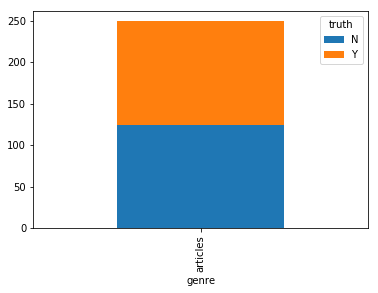

In [44]:
datasetEstudo.pivot_table(
    values='problemID',
    index=['genre'],
    columns='truth',aggfunc='count').plot.bar(stacked=True);

# analisando char n-grams  mais frequentes
Segundo a literatura (survery do stamatatos) o termos mais frequentes permitem diferenciar o autor sem ser impactados pelo contexto.
Estudando apontam também que entre 2 e 5 char n-grams apresentaram os melhores resultados.
Utilizando o TfidfVectorizer  sem a componente IDF porque ela faz pouco efeito e para utilizar a versão com 1+log(TF)

In [45]:
counter = TfidfVectorizer(
        analyzer="char",
        min_df=0.90,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float64
    );

In [46]:
XK = datasetEstudo.known.values;
XU = datasetEstudo.unknown.values;
Y = datasetEstudo.truth.values=="Y";

In [47]:
counter.fit(datasetEstudo.known.values); # em uma situação real só os textos dos autores conhecidos estariam disponíveis.
ma = counter.transform(datasetEstudo.known.values).todense();
mb = counter.transform(datasetEstudo.unknown.values).todense();

In [48]:
from sklearn.feature_selection import SelectFpr;
#calculado o DF
#mab = np.concatenate((ma, mb), axis=0);
#mab = np.avg(mab>0,axis=0) >;

known = normalize(ma);
unknown = normalize(mb);
sel = SelectFpr(alpha=0.2).fit(difchi2(known,unknown),Y);
known = sel.transform(known);
unknown = sel.transform(unknown);
known.shape


(250L, 1686L)

In [111]:
def pairwise_comparations(k, u):
    treshold = 0;
    return {
        'cosine': 1-cosine(k,u),
        'manhatan'  : np.diag(manhattan_distances(k,u)).flatten(),
        'stamatatos': CNG_Statamatos(k,u),
        'russellrao'   : np.diag(pairwise_distances(k > treshold, u >treshold, metric='russellrao')),
        'b2': b2(k,u),
        #'kl'   : KL_divergencev2(k,u),
        #'dmm'   : dminmax(k,u),
        #'rbf'   : 1-np.diag(rbf_kernel(k,u, gamma=1)).flatten(), #versão exponencial da euclidiana        
        #'keselj'    :CNG_Keselj(k,u),   #correlacionanda com jaccard
        'jaccard'   : np.diag(pairwise_distances(k > treshold, u >treshold, metric='jaccard')),
        #'rogerstanimoto'   : np.diag(pairwise_distances(k > 0, u >0, metric='rogerstanimoto')), #correlacionada com jaccard        
        #'chebyshev'   : np.diag(pairwise_distances(k,u, metric='chebyshev')),
        #'canberra'   : np.diag(pairwise_distances(k, u, metric='canberra'))/k.shape[1], 
        #'euclidean'   : np.diag(pairwise_distances(k, u, metric='euclidean')), 
    };

# analise descritiva das variáveis criadas

In [112]:
distances = pairwise_comparations(known, unknown);

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [113]:
Attr = pd.DataFrame(distances);
Attr.describe()

,b2,cosine,jaccard,manhatan,russellrao,stamatatos
count,2.50e+02,250.00,250.00,250.00,250.00,250.00
mean,1.58e-02,0.03,0.25,4.85,0.26,3.44
std,7.18e-04,0.01,0.05,0.68,0.05,0.53
min,1.41e-02,0.01,0.12,3.27,0.13,2.15
25%,1.53e-02,0.02,0.21,4.35,0.21,3.06
50%,1.57e-02,0.03,0.25,4.79,0.25,3.40
75%,1.63e-02,0.04,0.28,5.33,0.29,3.84
max,1.78e-02,0.07,0.43,6.77,0.46,5.23


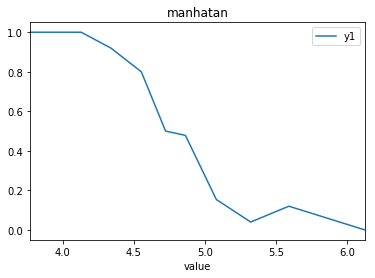

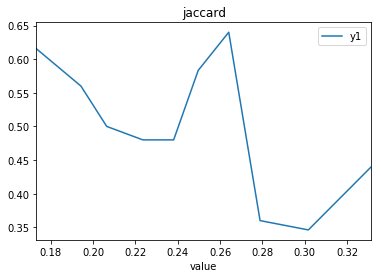

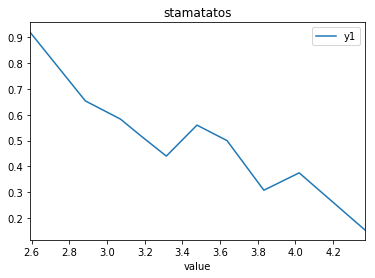

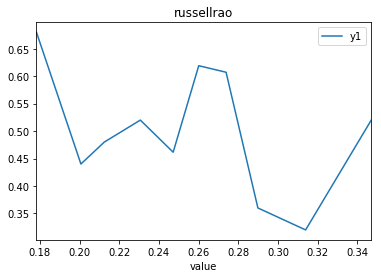

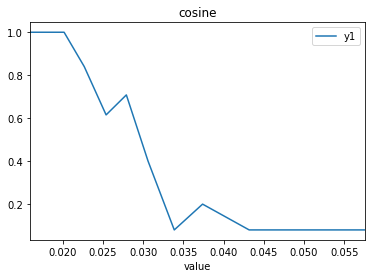

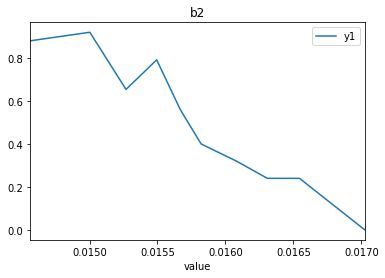

In [114]:
from sklearn.preprocessing import quantile_transform;
for f, v in distances.iteritems():
    df = pd.DataFrame({
        'quantile': np.ceil((quantile_transform(np.array(v).reshape(-1,1))*10).flatten()),
        'value':np.array(v),
        'y1':Y
    }).groupby(by='quantile').mean().reset_index().plot(x="value",y=['y1'], title=f);


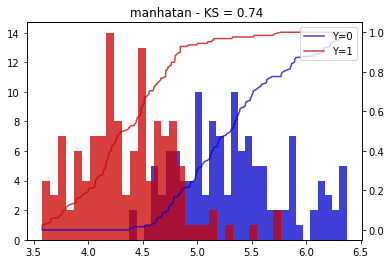

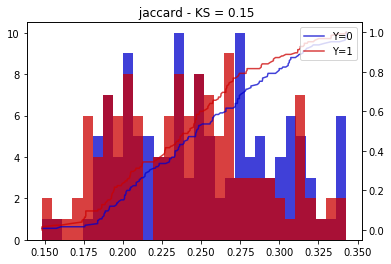

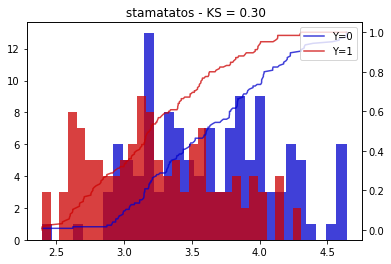

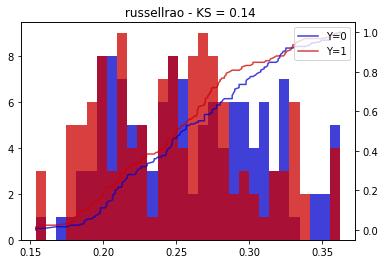

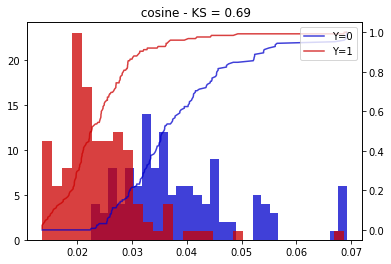

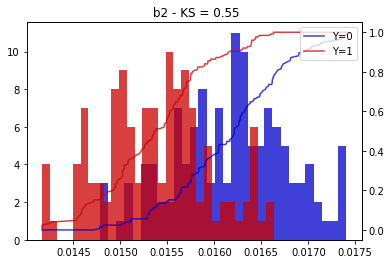

In [115]:
for f, v in distances.iteritems(): 
    v2 = np.clip(v, np.percentile(v,1), np.percentile(v,99));
    KS_Hist_chart(v2, Y, f);
    plt.show();

In [116]:
Y = datasetEstudo.truth.values=="Y";
KS = pd.DataFrame(
    {'Dissimilaridade':[f for f in distances],
      'Kolmogorov-Smirnov': [ ksCurve(distances[f],Y) for f in distances],
    'fClassifDF': [ int( (f_classif(distances[f].reshape(-1, 1), Y)[1])[0]*100) for f in distances]
    }
);
#KS.plot(kind='bar',x='Dissimilaridade', y='Kolmogorov-Smirnov');
pd.set_option('precision',2)
KS.sort_values(by='Kolmogorov-Smirnov', inplace=True, ascending=False)
KS.to_clipboard(excel=True);
KS


,Dissimilaridade,Kolmogorov-Smirnov,fClassifDF
0,manhatan,0.74,0
4,cosine,0.69,0
5,b2,0.55,0
2,stamatatos,0.30,0
1,jaccard,0.15,6
3,russellrao,0.14,13


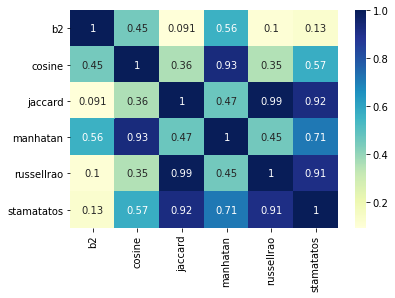

In [117]:
corr = Attr.corr()
sns.heatmap(corr.abs(),annot=True, cmap="YlGnBu",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

In [118]:
corr

,b2,cosine,jaccard,manhatan,russellrao,stamatatos
b2,1.00,0.45,-0.09,0.56,-0.10,0.13
cosine,0.45,1.00,0.36,0.93,0.35,0.57
jaccard,-0.09,0.36,1.00,0.47,0.99,0.92
manhatan,0.56,0.93,0.47,1.00,0.45,0.71
russellrao,-0.10,0.35,0.99,0.45,1.00,0.91
stamatatos,0.13,0.57,0.92,0.71,0.91,1.00


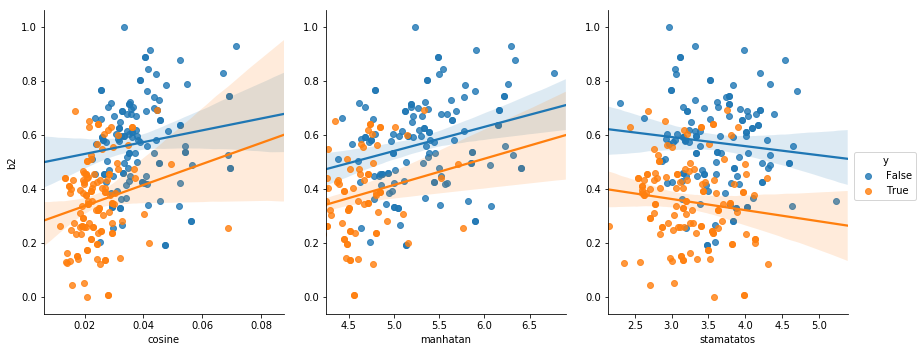

In [119]:
#sns.jointplot(x=distances["jaccard"][Y==0], y=distances["chebyshev"][Y==0], kind="reg");
#sns.jointplot(x=distances["jaccard"][Y==1], y=distances["chebyshev"][Y==1], kind="reg");
d = distances.copy();
d['y']=Y;
d['b2']=minmax_scale(d['b2']*100);
sns.pairplot(pd.DataFrame(d), x_vars=["cosine", "manhatan",'stamatatos'], y_vars=["b2"],  hue="y", size=5, aspect=.8, kind="reg");

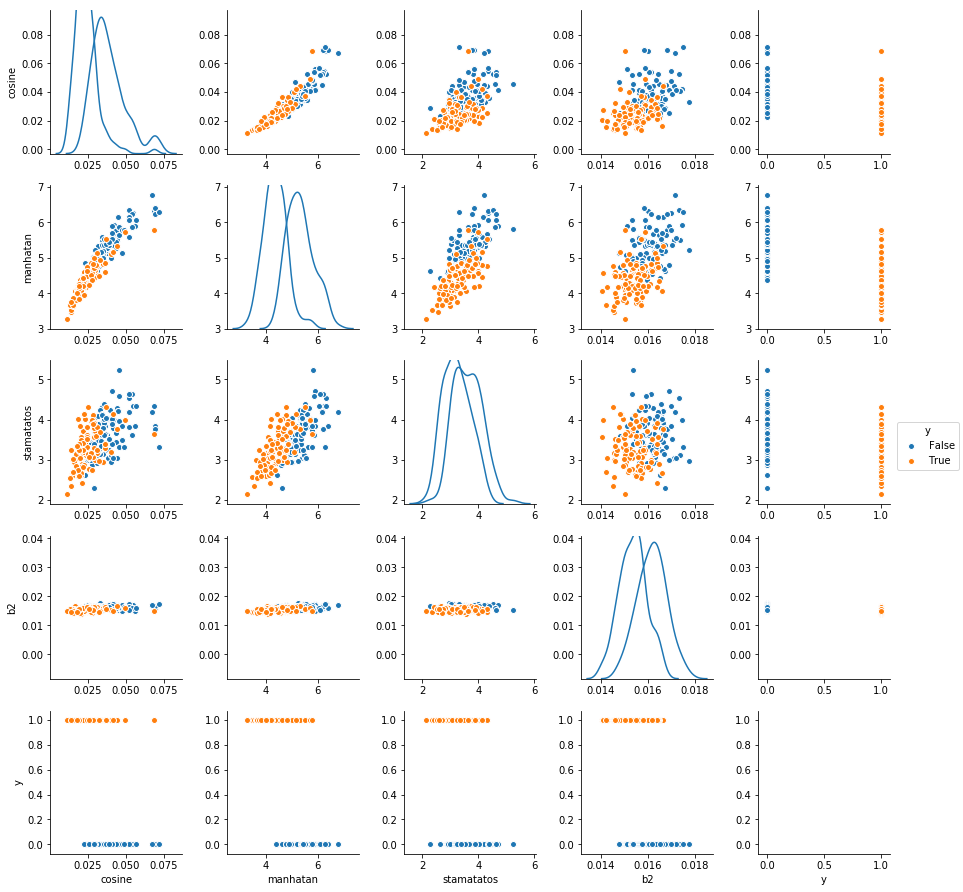

In [120]:
d = distances.copy();
d['y']=Y;
sns.pairplot(pd.DataFrame(d)[["cosine", "manhatan",'stamatatos','b2','y']], hue="y",diag_kind="kde");

In [121]:
from sklearn.preprocessing import minmax_scale;
Attr2 = pd.DataFrame(distances);
Attr2.drop([
    #'b2',
    #'manhatan', #11
    #'cosine', #23
    #'russellrao', #32
    #'stamatatos', #4
    #'jaccard',
],axis=1,inplace=True)
Attr2["intercept"] = 1.0;
model = sm.Logit(Y, Attr2 )
m = model.fit()
m.summary()

Optimization terminated successfully.
         Current function value: 0.198812
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                          Logit   Df Residuals:                      243
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Nov 2017   Pseudo R-squ.:                  0.7132
Time:                        00:35:04   Log-Likelihood:                -49.703
converged:                       True   LL-Null:                       -173.29
                                        LLR p-value:                 1.653e-50
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b2             7.9359    564.004      0.014      0.989   -1097.492    1113.364
cosine       297.3519     93.346      3.185      0.001     114.398     480.306
jaccard      -72.2655     59.395     -1.217      0.224    -188.677      44.146
manhatan     -12.3530      2.915     -4.238      0.000     -18.066      -6.640
russellrao   139.2517     59.296      2.348      0.019      23.034     255.469
stamatatos    -3.6900      2.810     -1.313      0.189      -9.198       1.818
intercept     45.5312      8.937      5.095      0.000      28.015      63.048
==============================================================================
"""

In [122]:
((m.params - m.params['intercept']) /m.bse) **2

b2            4.44e-03
cosine        7.28e+00
jaccard       3.93e+00
manhatan      3.94e+02
russellrao    2.50e+00
stamatatos    3.07e+02
intercept     0.00e+00
dtype: float64

# Classificador utilizando as funções de similiaridade

In [123]:
kf = StratifiedKFold(n_splits=10, random_state =0);

counter = CountVectorizer(
        analyzer="char",
        min_df=0.90,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float32
    );

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

In [124]:
modelsResults = [];

i =0;

for train_index, test_index in kf.split(XK, Y):
    i=i+1;
    print("\niniciando iteração %d" % i);
    
    XKtrain, XKtest = XK[train_index], XK[test_index];
    XUtrain, XUtest = XU[train_index], XU[test_index];
    YTrain , YTest  = Y[train_index] , Y[test_index];
    
    print("counter");
    counter.fit(XUtrain);
    XKtrain, XKtest = counter.transform(XKtrain).todense(), counter.transform(XKtest).todense();
    XUtrain, XUtest = counter.transform(XUtrain).todense(), counter.transform(XUtest).todense();
     
    
    XKtrain, XKtest  = normalize(XKtrain), normalize(XKtest);
    XUtrain, XUtest  = normalize(XUtrain), normalize(XUtest); 
    
    sel = SelectFpr(alpha=0.1).fit(np.abs(XKtrain-XUtrain),YTrain);
    
    XKtrain, XKtest = sel.transform(XKtrain), sel.transform(XKtest);
    XUtrain, XUtest = sel.transform(XUtrain), sel.transform(XUtest);
    
    
    print("X training");
    Xtrain = pairwise_comparations(XKtrain,XUtrain);
    
    print("X test");
    Xtest = pairwise_comparations(XKtest,XUtest);
    
    for k,v in Xtrain.iteritems():
            print("modelo "+k);
            pipeline.fit(v.reshape(-1,1),YTrain);
            predTrain = pipeline.predict_proba(v.reshape(-1,1));
            predTest = pipeline.predict_proba(Xtest[k].reshape(-1,1));

            modelsResults.append({        
                'kfold'     : i,
                'model'     :k,
                'stage': 'test',
                'kpi' : kpi2(predTest[:,1],YTest),
            });
            modelsResults.append({        
                'kfold'     : i,
                'model'     :k,
                'stage': 'train',
                'kpi': kpi2(predTrain[:,1],YTrain),
            });
    
    print("modelo  mix");
    Xtrain = np.vstack((Xtrain[v] for v in Xtrain)).T;
    Xtest  = np.vstack((Xtest[v] for v in Xtest)).T;
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'mix',
        'stage': 'test',
        'kpi' : kpi2(predTest[:,1],YTest),
    });
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'mix',
        'stage': 'train',
        'kpi':  kpi2(predTrain[:,1],YTrain),
    });
    
    print("modelo CNG distancia 1");
    Xtrain = dist(XKtrain,XUtrain);
    Xtest = dist(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'dif',
        'stage': 'test',
        'kpi' : kpi2(predTest[:,1],YTest),
    });
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'dif',
        'stage': 'train',
        'kpi':  kpi2(predTrain[:,1],YTrain),
    });
    
    print("modelo CNG distancia 2");
    Xtrain = difchi2(XKtrain,XUtrain);
    Xtest = difchi2(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'dif2',
        'stage': 'test',
        'kpi' : kpi2(predTest[:,1],YTest),
    });
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'dif2',
        'stage': 'train',
        'kpi':  kpi2(predTrain[:,1],YTrain),
    });


iniciando iteração 1
counter
X training
X test
modelo manhatan
modelo jaccard
modelo stamatatos
modelo russellrao
modelo cosine
modelo b2
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 2
counter


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


X training
X test
modelo manhatan
modelo jaccard
modelo stamatatos
modelo russellrao
modelo cosine
modelo b2
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 3
counter
X training
X test
modelo manhatan
modelo jaccard
modelo stamatatos
modelo russellrao
modelo cosine
modelo b2
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 4
counter
X training
X test
modelo manhatan
modelo jaccard
modelo stamatatos
modelo russellrao
modelo cosine
modelo b2
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 5
counter
X training
X test
modelo manhatan
modelo jaccard
modelo stamatatos
modelo russellrao
modelo cosine
modelo b2
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 6
counter
X training
X test
modelo manhatan
modelo jaccard
modelo stamatatos
modelo russellrao
modelo cosine
modelo b2
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 7
counter
X training
X te

In [63]:
def transfResults(r):
    c = r.copy();
    kpi = c['kpi'];
    del c['kpi'];
    c.update(kpi);
    return c;
pd.DataFrame(map(transfResults, modelsResults)).groupby(by=['stage','model']).mean()

C_score   PAN  acuracia   auc    f1  kfold    ks
stage model                                                       
test  b2             0.65  0.45      0.64  0.67  0.65    5.5  0.50
      cosine         0.76  0.65      0.76  0.85  0.78    5.5  0.66
      dif            0.80  0.67      0.79  0.79  0.80    5.5  0.65
      dif2           0.82  0.71      0.82  0.83  0.83    5.5  0.68
      jaccard        0.55  0.32      0.56  0.56  0.57    5.5  0.34
      manhatan       0.79  0.70      0.79  0.87  0.79    5.5  0.69
      mix            0.79  0.70      0.79  0.88  0.78    5.5  0.69
      russellrao     0.55  0.32      0.56  0.56  0.57    5.5  0.34
      stamatatos     0.73  0.58      0.73  0.78  0.71    5.5  0.56
train b2             0.70  0.53      0.70  0.76  0.70    5.5  0.44
      cosine         0.81  0.73      0.81  0.89  0.82    5.5  0.67
      dif            1.00  1.00      1.00  1.00  1.00    5.5  1.00
      dif2           1.00  1.00      1.00  1.00  1.00    5.5  0.99
      jaccard        0.55  0.32      0.56  0.58  0.60    5.5  0.17
      manhatan       0.86  0.81      0.86  0.94  0.86    5.5  0.76
      mix            0.88  0.84      0.88  0.95  0.88    5.5  0.79
      russellrao     0.55  0.32      0.56  0.58  0.60    5.5  0.17
      stamatatos     0.79  0.67      0.78  0.86  0.79    5.5  0.59

In [64]:
pd.DataFrame(map(transfResults, modelsResults))\
.pivot_table(values=['acuracia','f1','auc','PAN','ks'],index=['model'],columns='stage',aggfunc='mean') \


PAN       acuracia         auc          f1          ks      
stage       test train     test train  test train  test train  test train
model                                                                    
b2          0.45  0.53     0.64  0.70  0.67  0.76  0.65  0.70  0.50  0.44
cosine      0.65  0.73     0.76  0.81  0.85  0.89  0.78  0.82  0.66  0.67
dif         0.67  1.00     0.79  1.00  0.79  1.00  0.80  1.00  0.65  1.00
dif2        0.71  1.00     0.82  1.00  0.83  1.00  0.83  1.00  0.68  0.99
jaccard     0.32  0.32     0.56  0.56  0.56  0.58  0.57  0.60  0.34  0.17
manhatan    0.70  0.81     0.79  0.86  0.87  0.94  0.79  0.86  0.69  0.76
mix         0.70  0.84     0.79  0.88  0.88  0.95  0.78  0.88  0.69  0.79
russellrao  0.32  0.32     0.56  0.56  0.56  0.58  0.57  0.60  0.34  0.17
stamatatos  0.58  0.67     0.73  0.78  0.78  0.86  0.71  0.79  0.56  0.59

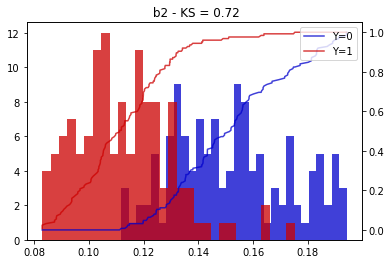

In [151]:
def Bhattacharyya(C,D):
    a =0.001;
    bc = 100*np.nanmean(np.abs(C-D)**2/(np.maximum(C,D)+a), axis=1);
    
    return bc; 

v = Bhattacharyya(known, unknown);
v2 = np.clip(v, np.percentile(v,1), np.percentile(v,99));
KS_Hist_chart(v2, Y, f);
plt.show();

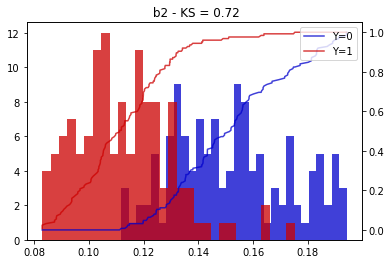

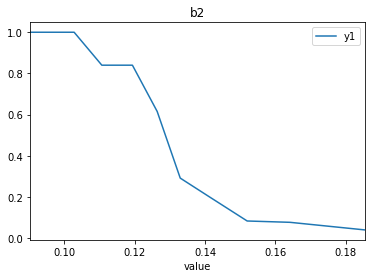

In [153]:
#v = np.log(np.nansum(np.abs(known-unknown)**2,axis=1));
v2 = np.clip(v, np.percentile(v,1), np.percentile(v,99));
KS_Hist_chart(v2, Y, f);
#plt.show();

df = pd.DataFrame({
    'quantile': np.ceil((quantile_transform(np.array(v).reshape(-1,1))*10).flatten()),
    'value':np.array(v),
    'y1':Y
}).groupby(by='quantile').mean().reset_index().plot(x="value",y=['y1'], title=f);